In [1]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Challenge 1 set 1
-----------------

In [2]:
# loading challenge 1 into memory
# -- for gwpy
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge1.gwf', channel="H1:CHALLENGE1")
# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge1.gwf', 'H1:CHALLENGE1')

/opt/conda/lib/python3.8/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
# printing sampling rate and duration
print("Sampling rate:", gwpy_strain.sample_rate)
print("Duration:", gwpy_strain.dt * len(gwpy_strain.times))

Sampling rate: 4096.0 Hz
Duration: 128.0 s


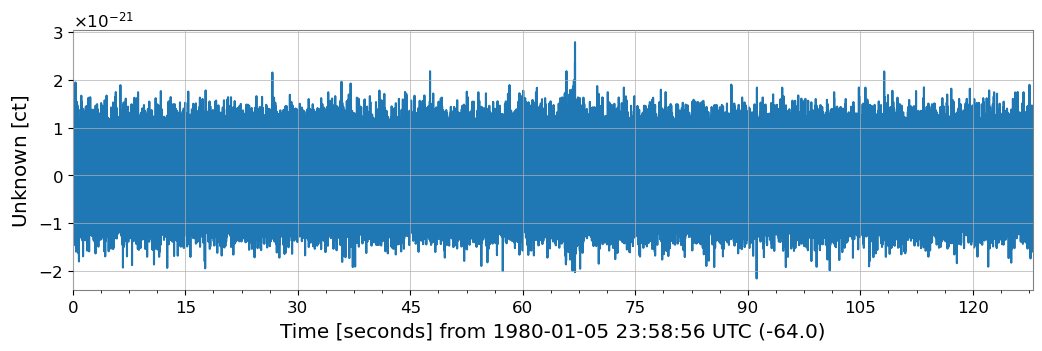

In [4]:
# plotting data in time domain
%matplotlib inline
plot = gwpy_strain.plot()

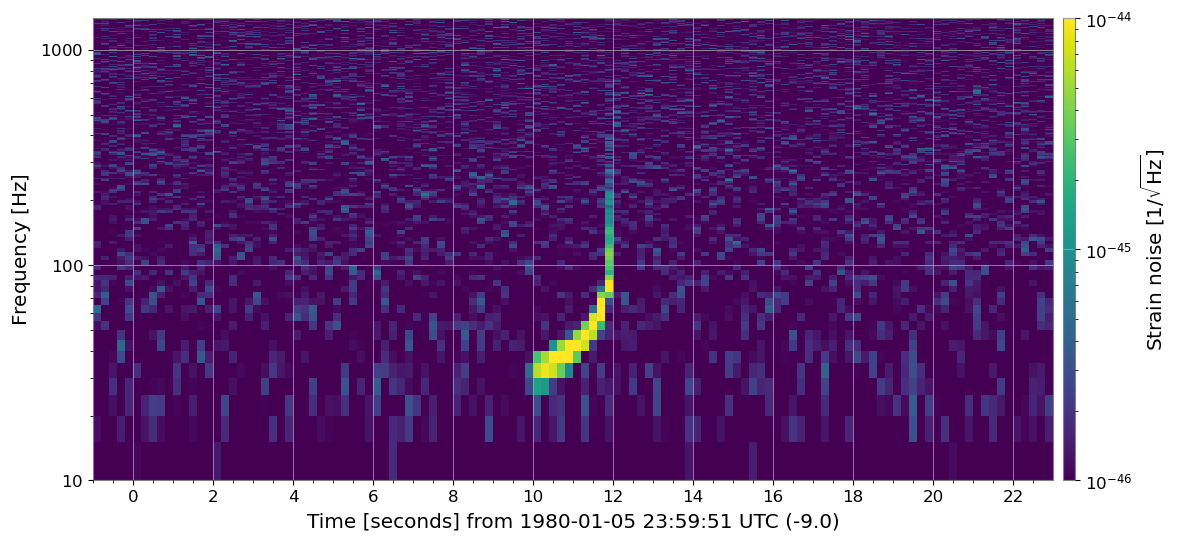

In [5]:
# plotting spectrogram of data
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

spectrogram = TimeSeries.spectrogram(gwpy_strain, stride=0.2)
plot = spectrogram.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.set_xlim(-10, 14)
ax.colorbar(
    clim=(1e-46, 1e-44),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)

Looking at this graph, the merger must have happened at around 3 seconds (12 - 9.0)

Challenge 2 set 1
-----------------

In [6]:
# loading challenge 2 into memory
# -- for gwpy
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")
# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

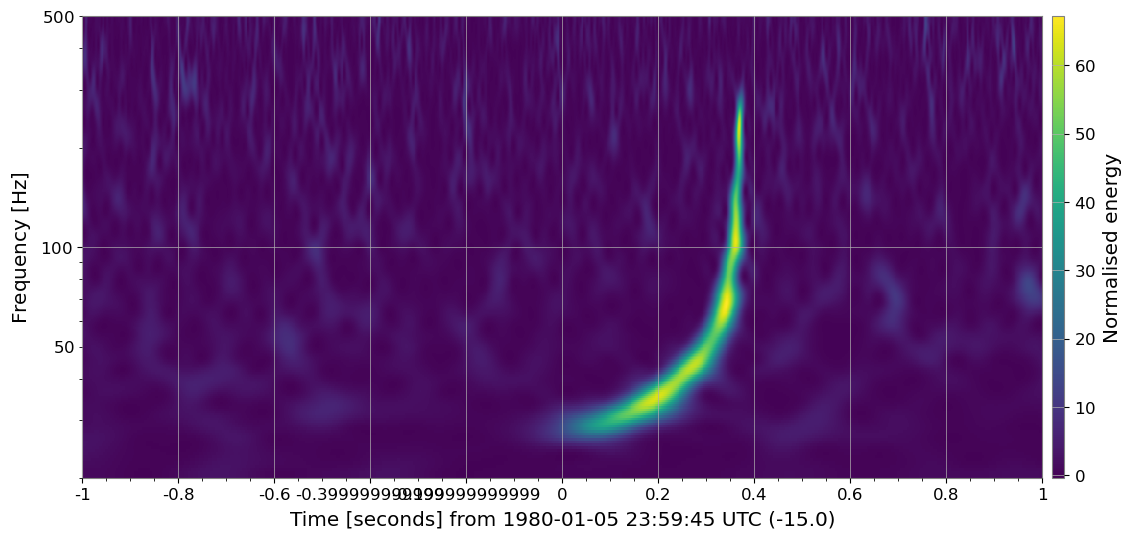

In [7]:
# plot of q-transform
hq = gwpy_strain.q_transform(frange=(20, 500), qrange=(10, 50), outseg=(48 - 64, 50 - 64))
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

Merger at around -14.6 seconds (0.4- 15.0)

In [8]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

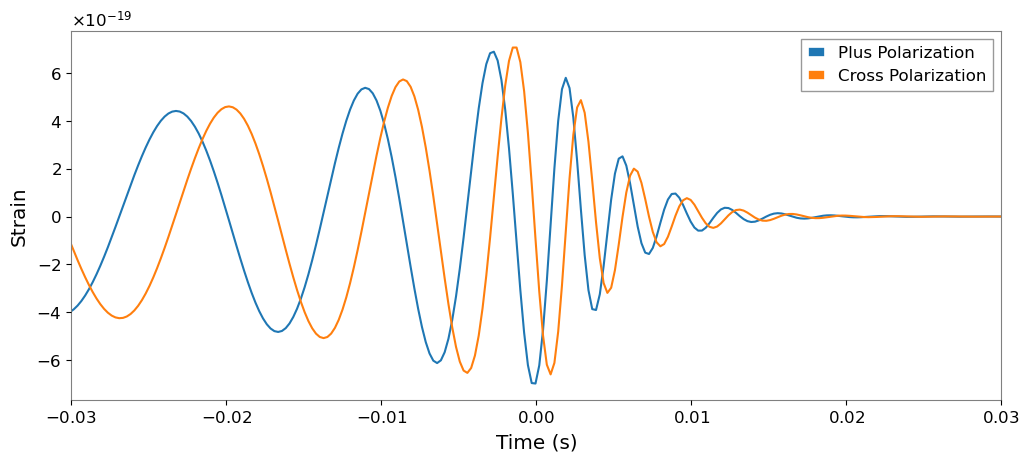

In [9]:
# generating waveform
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         spin=0,
                         delta_t=1.0/4096,
                         f_lower=20)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.03, .03)
pylab.legend()
pylab.grid()
pylab.show()

In [10]:
from pycbc import frame
strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

conditioned = strain.crop(2, 2)
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency.
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=20)



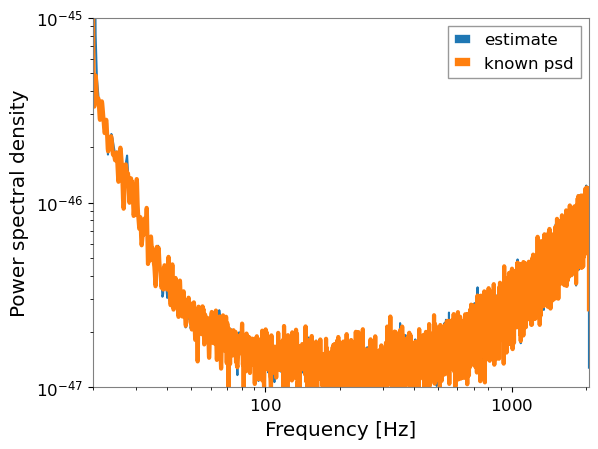

In [11]:
# http://pycbc.org/pycbc/latest/html/noise.html
import pycbc.noise
import pycbc.psd

sample_rate = 4096 # samples per second
data_length = 1024 # seconds

delta_f = conditioned.delta_f
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Estimate the amplitude spectral density (ASD = sqrt(PSD)) for the noisy data
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,seg_len=seg_len,seg_stride=seg_stride)

# plot it:
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pylab.xlim(xmin=20, xmax=sample_rate/2)
pylab.ylim(1e-47, 1e-45)
pylab.xlabel('Frequency [Hz]')
pylab.ylabel('Power spectral density')
pylab.legend()
pylab.grid()
pylab.show()

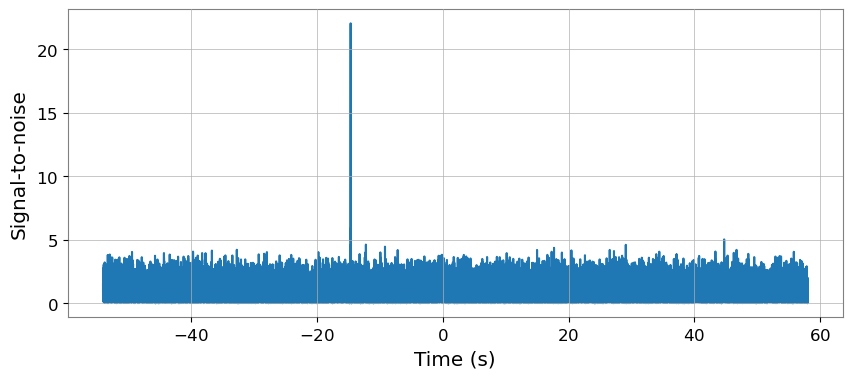

We found a signal at -14.6328125s with SNR 22.05075553190347


In [12]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for
# so short a template). A longer signal such as from a BNS, would
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

Challenge 2 set 2
---

In [13]:
# loading data
import pycbc.types
import numpy

d = numpy.load('noise_ts_4096Hz.npy')
time = d[:, 0]
strain = d[:, 1]
dt = time[1] - time[0]
data = pycbc.types.TimeSeries(d[:, 1], delta_t = dt)

In [14]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

# generate waveform within given range of 5-10
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=5,
                         mass2=5,
                         delta_t=1.0/4096,
                         f_lower=15)

In [15]:
conditioned = data.crop(2, 2)
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency.
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)


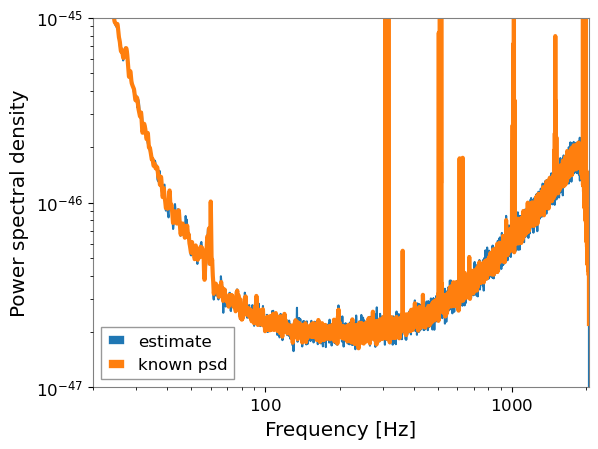

In [16]:
import pycbc.noise
import pycbc.psd

sample_rate = 4096 # samples per second
data_length = 1024 # seconds

delta_f = conditioned.delta_f
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Estimate the amplitude spectral density (ASD = sqrt(PSD)) for the noisy data
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,seg_len=seg_len,seg_stride=seg_stride)

# plot it:
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pylab.xlim(xmin=20, xmax=sample_rate/2)
pylab.ylim(1e-47, 1e-45)
pylab.xlabel('Frequency [Hz]')
pylab.ylabel('Power spectral density')
pylab.legend()
pylab.grid()
pylab.show()

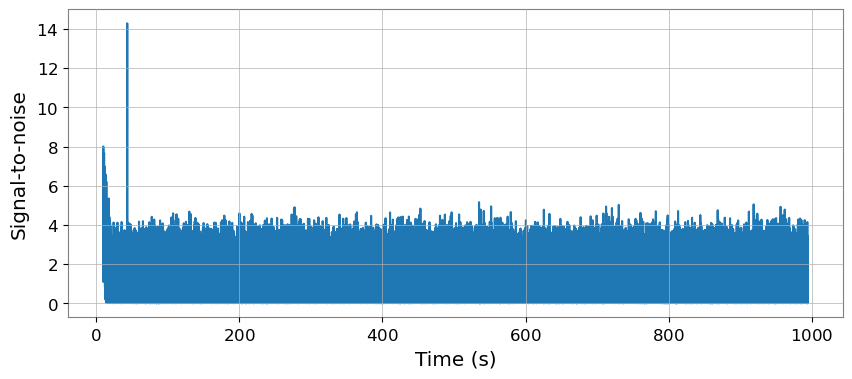

We found a signal at 43.590087890250004s with SNR 14.285851376878771


In [17]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for
# so short a template). A longer signal such as from a BNS, would
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

This SNR value crosses the threshold of 8

In [18]:
# We do it this way so that we can whiten both the template and the data
import pycbc.psd
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_data=white_data.crop(4,4)

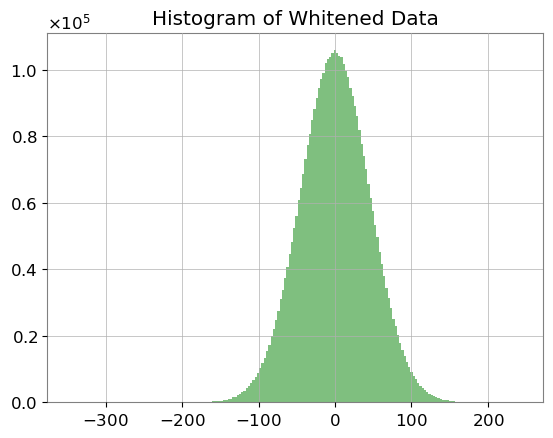

In [23]:
# plotting histogram of whitened data
import matplotlib.pyplot as plt
num_bins = 200
n, bins, patches = plt.hist(white_data, num_bins, facecolor='green', alpha=0.5)
plt.title("Histogram of Whitened Data")
plt.show()

This resembles a Gaussian distribution with mean of 0

In [24]:
# generating waveform
from pycbc.waveform import get_fd_waveform
hp, hc = get_fd_waveform(approximant="TaylorF2",
    mass1=3,
    mass2=3,
    delta_f=psd.delta_f,
    distance = 500,
    f_lower=20.0, f_final = 2048.0) #Luminosity distance = 500 Mpc

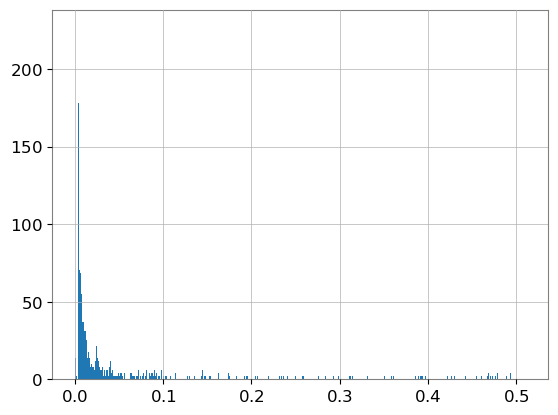

In [25]:
# test whether noise follows stationary Gaussian assumption
from pycbc.filter import sigmasq
snr_list = []

# splitting up hp and psd into 7937 chunks of 257 data points
for i in range(7937):
  SNR = (pycbc.filter.sigmasq(hp[i*257:i*257+258], psd[i*257:i*257+258]))**0.5  
  snr_list.append(SNR)

plt.hist(snr_list, 7937, density=True)
pylab.show()  

As can be seen, the stationary Gaussian assumption does not hold here